# Getting started with Task 2

Instructions:
- Download the dataset from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
- Unzip the `archive.zip` file
- Rename the folder `archive` as `ecg_dataset` and place it in the root of the git repository

References:
- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

## Load dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
drive_path = '/content/drive/MyDrive/cardiac_challenge_team6'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time as currentTime

## MIT-BIH  Arrhythmia Dataset

- Number of Samples: 109446
- Number of Categories: 5
- Sampling Frequency: 125Hz
- Data Source: Physionet's MIT-BIH Arrhythmia Dataset
- Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.


The shape of the mitbih_train is :  (87554, 188)
The shape of the mitbih_test is :  (21892, 188)
The last time value is :  1488.0


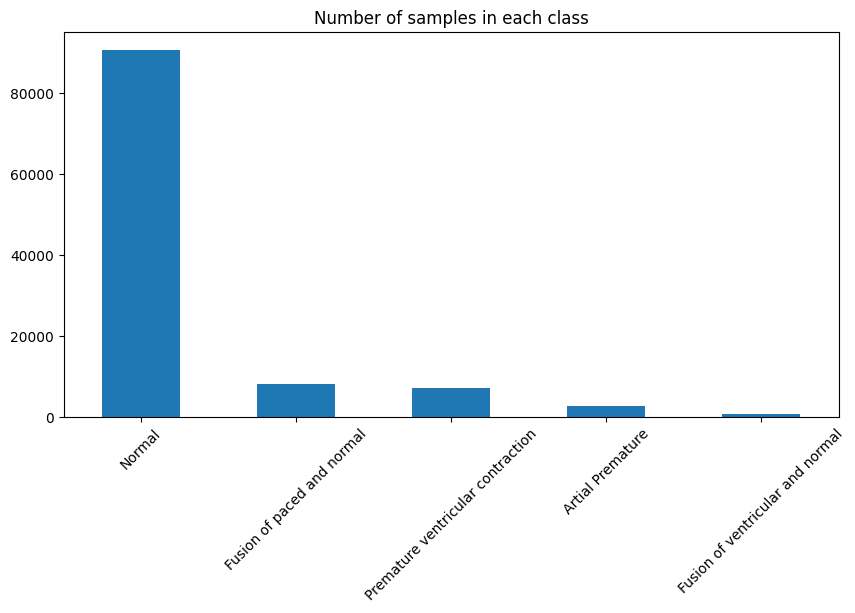

In [4]:
df_mitbih_train = pd.read_csv(f"{drive_path}/ecg_dataset/mitbih_train.csv", header = None)
df_mitbih_test = pd.read_csv(f"{drive_path}/ecg_dataset/mitbih_test.csv", header = None)

# print shapes of the dataframes
print("The shape of the mitbih_train is : ", df_mitbih_train.shape)
print("The shape of the mitbih_test is : ", df_mitbih_test.shape)

df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
#df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)

labels=[]
for i in range(len(id_to_label)):
    labels.append(id_to_label[i])

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_mitbih.shape[1] - 1
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_mitbih.columns = list(time) + ["label"]

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_mitbih["label"].value_counts()
# substitute the class names
counts.index = counts.index.map(id_to_label)
# create a figure
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 45)
plt.title("Number of samples in each class")
plt.show()

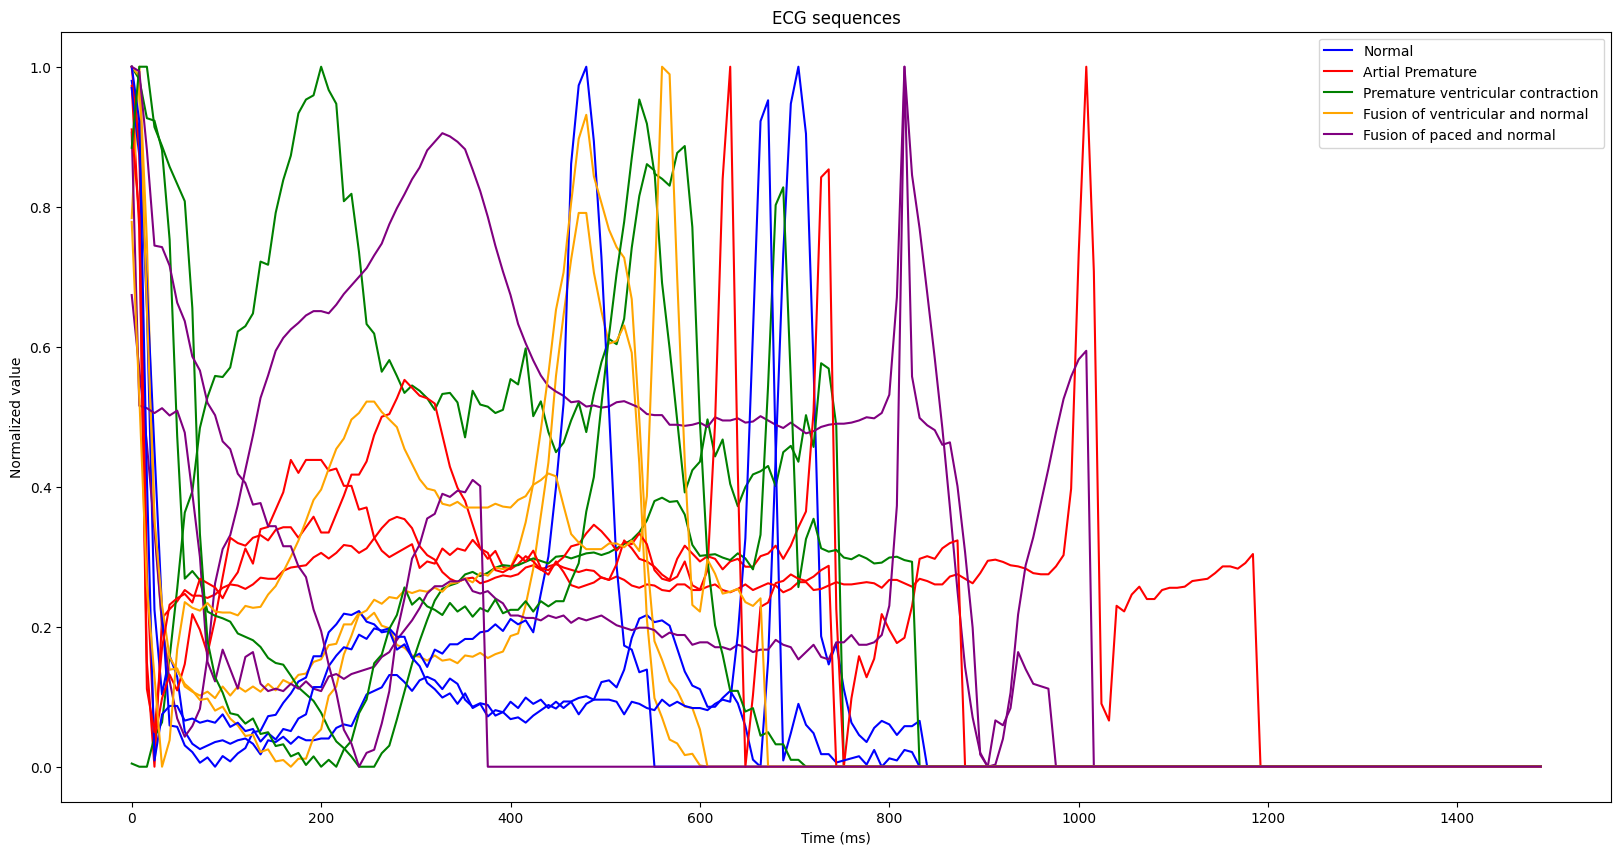

In [5]:
# create a figure
plt.figure(figsize = (20, 10))
# define colors for each class
colors = ["blue", "red", "green", "orange", "purple"]
# plot the normal sequences
for i in range(3):
    for label in id_to_label.keys():
        # sample a random sequence from that label
        df_mitbih_label = df_mitbih[df_mitbih["label"] == label].sample(1)
        # plot the sequence
        if i == 0:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], label = id_to_label[label], color = colors[label])
        else:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], color = colors[label])
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [6]:
from sklearn.model_selection import train_test_split
import torch

from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader

from sklearn import metrics

In [7]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

In [8]:
def show_plot(train_pred, train_actual, test_pred, test_actual):
    plt.scatter(train_actual, train_pred, color='darkcyan', alpha=0.005)
    plt.scatter(test_actual, test_pred, color='lightcoral', alpha=0.005)
    plt.show()
    plt.close()

In [9]:
#return accuracy of classifications for each true label
def getClassAccuracies(conf_mat):
    class_ = 0
    classAccuracy = []
    for i in conf_mat:
        total = i.sum()
        correctClass = i[class_]
        classAccuracy.append(str((correctClass/total)*100)[:5]+'%')
        class_+=1
    return classAccuracy

In [10]:
df = df_mitbih

In [11]:
features=[]
for i in range(len(df.iloc[:,1])):
    features.append(np.asarray(df.iloc[i,:]))

features = np.asarray(features)

X = features[:, :(len(df.iloc[1,:])-1)]
Y = features[:, (len(df.iloc[1,:])-1)]

tensorX = torch.from_numpy(X).type(torch.float)
tensorY = torch.from_numpy(Y).type(torch.float)

x_train, x_test, y_train, y_test = train_test_split(tensorX, tensorY, test_size=0.2, random_state=12345)

In [12]:
class NN_Classifier(nn.Module):
    def __init__(self, input_dim):
        super(NN_Classifier, self).__init__()

        self.lin1 = nn.Linear(input_dim, 123)

        conv_ks = 4 # conv1d kernel_size
        self.conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=conv_ks)

        pool_ks = 2 # MaxPool1d kernel_size
        self.pool = nn.MaxPool1d(kernel_size=pool_ks)

        self.fc1 = nn.Linear(int((123-(conv_ks-1))/pool_ks), 40)

        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(40, 5)
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.lin1(x)
        x = x.unsqueeze(1) # add channel dimension of 1 for conv1d
        x = self.conv(x)
        x = x.squeeze(1) # remove channel dimension of 1 from conv1d
        x = self.relu(x)

        x = self.pool(x)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
#         x = self.relu(x)

        return x

In [13]:
# average loss function with some tweaks
def myLossFn(predictions, target):
    per_class_loss = nn.functional.cross_entropy(predictions, target.long(), reduction='none')
    avgLoss=0
    num_classes = predictions.size(1)
    for class_num in range(num_classes):
        class_loss = per_class_loss[target.long() == class_num].mean()

        # make class 1 loss slightly more sensitive because there are not as many samples
        if(class_num==1):
            class_loss*=1.25

        # make class 3 loss even more sensitive because there are a very small amount of samples
        if(class_num==3):
            class_loss*=1.25

        if(class_num==0):
            class_loss*=0.6

        avgLoss+=class_loss
    avgLoss/=(num_classes)

    return avgLoss

In [14]:
#create instance of CNN Image Classifier
classify = NN_Classifier(187).to(device)

#optimizer, lr = learning rate
opt = Adam(classify.parameters(), lr=1e-3)

# total loss function
loss_fn = nn.CrossEntropyLoss()

In [15]:
g = x_test.to(device)
untrained_preds = classify(g)

In [16]:
# print(myLossFn(untrained_preds, y_test))

In [17]:
num_epochs = 200

In [18]:
train_time = True
updateModel = True

In [19]:
# Training flow
if (train_time):

    train = []
    for i in range(len(x_train)):
        train.append((x_train[i], y_train[i]))

    trainloader = DataLoader(train, 300)

    leastLoss = 2

    for epoch in range(1, num_epochs+1):

        for batch in trainloader:

            X,Y = batch
            X, Y = X.to(device), Y.to(device)
            Yhat = classify(X)

            # print(Y.shape)
            # print(Yhat.shape)

            loss = torch.tensor(0.0)
            loss += myLossFn(Yhat, Y)

            if (loss.item() < leastLoss):

                leastLoss = loss.item()
                leastLossEpoch = epoch

                if (updateModel):
                  #save trained model with least loss
                  with open(f'{drive_path}/trained_models/trained_model_task_2.pt', 'wb') as f:
                      save(classify.state_dict(), f)

            #backpropogation
            opt.zero_grad()
            loss.backward()
            opt.step()

        #print loss for every 25 epochs
        if (epoch%25==0):
            print(f"Epoch {epoch} loss is {loss.item()}")

#     if (updateModel):
#         #save trained model
#         with open('trained_model_task_2.pt', 'wb') as f:
#             save(classify.state_dict(), f)

    print(f'Epoch with least loss: {leastLossEpoch} | Loss: {leastLoss}')

Epoch 25 loss is 0.12051089107990265
Epoch 50 loss is 0.061678510159254074
Epoch 75 loss is 0.0457509309053421
Epoch 100 loss is 0.048153407871723175
Epoch 125 loss is 0.04175027832388878
Epoch 150 loss is 0.0421636626124382
Epoch 175 loss is 0.03116900846362114
Epoch 200 loss is 0.013606538996100426
Epoch with least loss: 189 | Loss: 0.0029315182473510504


In [20]:
if (not train_time):
  #load previously trained model
  with open(f'{drive_path}/trained_models/trained_model_task_2.pt', 'rb') as f:
          classify.load_state_dict(load(f))

In [32]:
test_preds = classify(x_test)

In [33]:
test_classes = []
for t in test_preds:
    test_classes.append(int(torch.argmax(t)))

In [34]:
test_classes_tensors = torch.as_tensor(test_classes)

In [35]:
correct = test_classes_tensors == y_test

In [36]:
accuracy = correct.tolist().count(True)/len(correct)

In [37]:
# return accuracy of classifications for each true label
def getClassAccuracies(conf_mat):
    class_ = 0
    classAccuracy = []
    for i in conf_mat:
        total = i.sum()
        correctClass = i[class_]
        classAccuracy.append(str((correctClass/total)*100)[:5]+'%')
        class_+=1
    return classAccuracy

In [38]:
print(f'Overall Test Accuracy: {str(accuracy*100)[:5]}%')

confusion_matrix = metrics.confusion_matrix(y_test, test_classes)

# print accuracies for each true label
# ca = getClassAccuracies(confusion_matrix)
# class_= 0
# for a in ca:
#     print(f'Accuracy when true label is \'{id_to_label[class_]}\': {a}')
#     class_+=1

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

# cm_display.plot()
# plt.show()

Overall Test Accuracy: 95.35%


In [39]:
cm_percent = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis] * 100

In [40]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_percent)
# cm_display.plot()
# plt.show()

In [41]:
import seaborn as sns

confusion_matrix = cm_percent
# sns.heatmap(cm_percent, annot=True,cmap="Blues").set(title='Neural Network Confusion Matrix')

# plt.ylabel('True Class')
# plt.xlabel('Predicted Class')

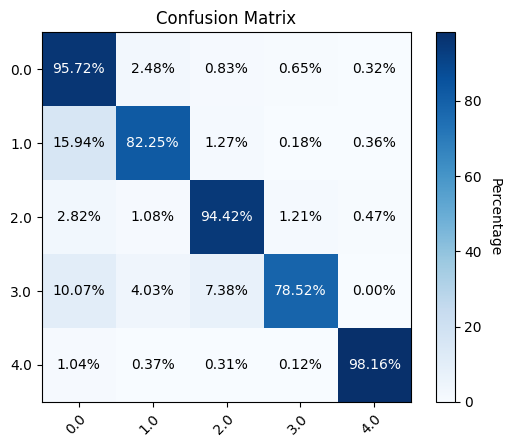

In [42]:
from sklearn.utils.multiclass import unique_labels

# Get class labels
class_labels = unique_labels(y_test, test_classes)

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the confusion matrix
im = ax.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the labels of the colorbar
cbar.ax.set_ylabel('Percentage', rotation=-90, va="bottom")

# Set the tick marks and labels
tick_marks = np.arange(len(class_labels))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

# Set the axis labels
# ax.set_xlabel('Predicted label')
# ax.set_ylabel('True label')

# Rotate the tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        ax.text(j, i, f'{cm_percent[i, j]:.2f}%',
                ha="center", va="center",
                color="white" if cm_percent[i, j] > 50 else "black")

# Set the title
ax.set_title('Confusion Matrix')

# Display the plot
plt.show()